<a href="https://colab.research.google.com/github/GabrielWalak/Eksploracja-danych/blob/main/ZadanieEDA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 Wymiary: (1460, 81)
 Zmiennych numerycznych: 38
 Zmiennych kategorycznych: 43

 CENY DOMÓW:
   Średnia: $180,921
   Mediana: $163,000
   Min: $34,900
   Max: $755,000
   Outliers: 61 (4.2%)
   Skośność: 1.88 (rozkład prawostronnie skośny)

 KORELACJE POWIERZCHNI Z CENĄ:
   GrLivArea: 0.709
   GarageArea: 0.623
   TotalBsmtSF: 0.614

 Wykres zapisany: eda.png


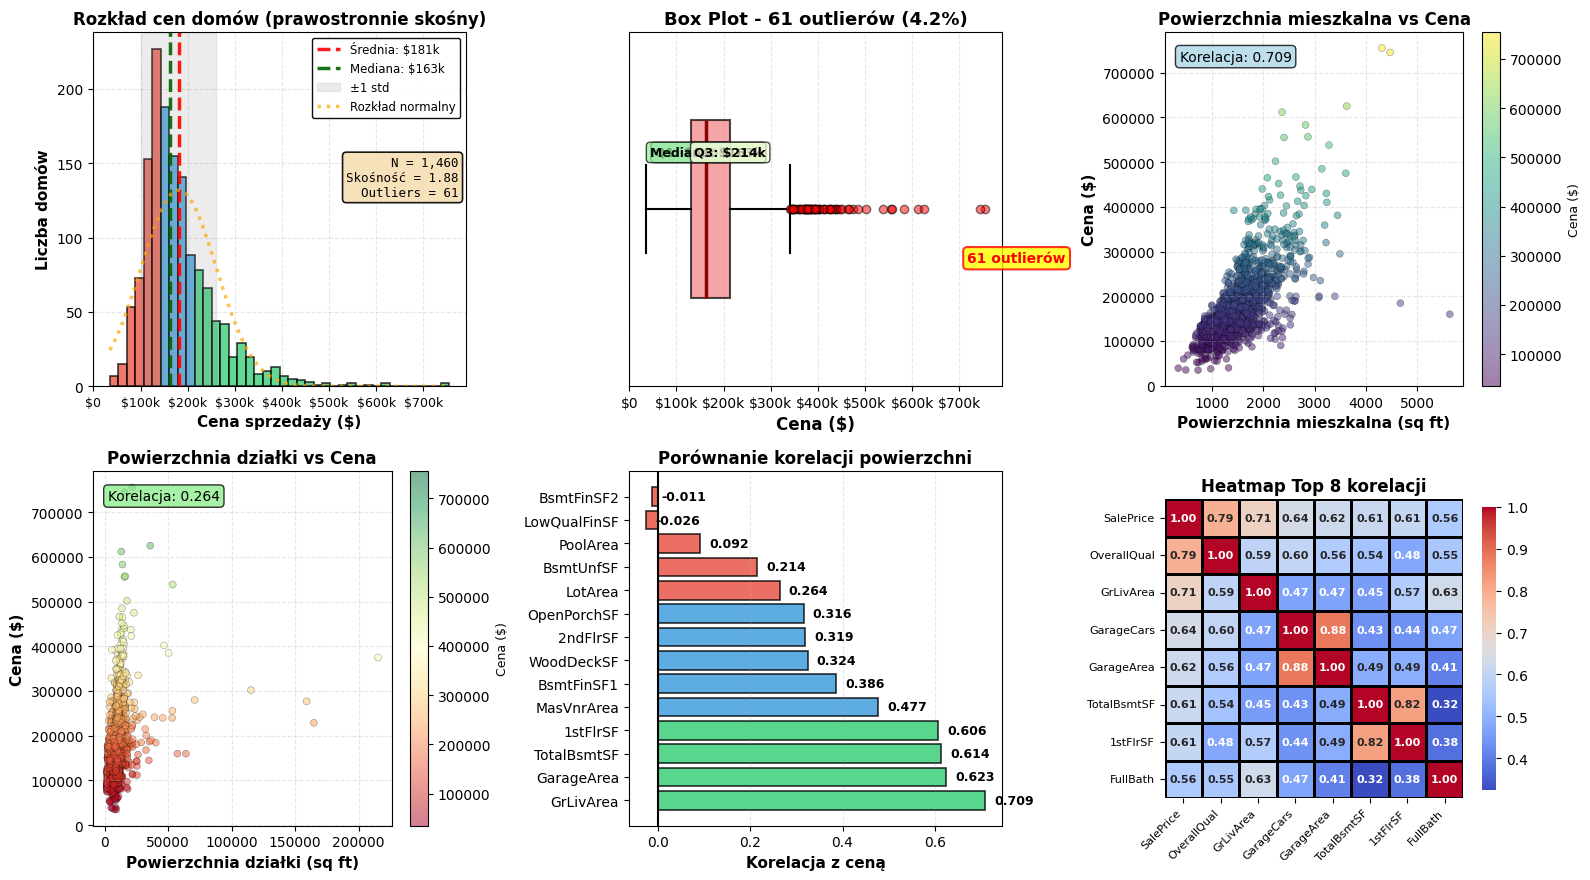

WNIOSKI

Zmienna docelowa: SalePrice
Rozkład: Prawostronnie skośny (skewness=1.88)
   - Większość domów jest w przedziale $130k - $214k
   - Mediana ($163k) < Średnia ($181k) potwierdza skośność
Outliers: 61 bardzo drogich domów (4.2%)
Hipoteza potwierdzona: Większe domy są droższe
Najsilniejszy związek: GrLivArea (powierzchnia mieszkalna) r=0.709
Powierzchnia działki ma SŁABSZY wpływ: LotArea r=0.264
Inne ważne zmienne: OverallQual, GarageCars (widoczne na heatmap)



In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker

train_df = pd.read_csv('train.csv')
print(f"\n Wymiary: {train_df.shape}")
print(f" Zmiennych numerycznych: {len(train_df.select_dtypes(include=[np.number]).columns)}")
print(f" Zmiennych kategorycznych: {len(train_df.select_dtypes(include=['object']).columns)}")

price = train_df['SalePrice']

print(f"\n CENY DOMÓW:")
print(f"   Średnia: ${price.mean():,.0f}")
print(f"   Mediana: ${price.median():,.0f}")
print(f"   Min: ${price.min():,.0f}")
print(f"   Max: ${price.max():,.0f}")

# Outliers
Q1, Q3 = price.quantile(0.25), price.quantile(0.75)
IQR = Q3 - Q1
outliers = price[price > Q3 + 1.5 * IQR]
print(f"   Outliers: {len(outliers)} ({len(outliers)/len(price)*100:.1f}%)")
print(f"   Skośność: {price.skew():.2f} (rozkład prawostronnie skośny)")

# KORELACJE POWIERZCHNI Z CENĄ
area_cols = [col for col in train_df.columns if 'Area' in col or 'SF' in col]
correlations = {col: train_df[col].corr(price)
                for col in area_cols
                if train_df[col].dtype in [np.int64, np.float64]}
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))

print(f"\n KORELACJE POWIERZCHNI Z CENĄ:")
for col, corr in list(correlations.items())[:3]:
    print(f"   {col}: {corr:.3f}")

# 5. WYKRESY - 6 NAJWAŻNIEJSZYCH
fig = plt.figure(figsize=(16, 9))

# 1. ULEPSZONE HISTOGRAM - WIĘKSZY I BARDZIEJ SZCZEGÓŁOWY
ax1 = plt.subplot(2, 3, 1)

mean_price = price.mean()
median_price = price.median()
std_price = price.std()
skewness = price.skew()

# Histogram z kolorowaniem według zakresu cenowego
n, bins, patches = ax1.hist(price, bins=40, edgecolor='black',
                            alpha=0.75, linewidth=1.2)

# Kolorowanie słupków
for i in range(len(patches)):
    if bins[i] < Q1:
        patches[i].set_facecolor('#e74c3c')
    elif bins[i] > Q3:
        patches[i].set_facecolor('#2ecc71')
    else:
        patches[i].set_facecolor('#3498db')

# Linie statystyczne
ax1.axvline(mean_price, color='red', linestyle='--', linewidth=2.5,
           label=f'Średnia: ${mean_price/1000:.0f}k', alpha=0.9)
ax1.axvline(median_price, color='darkgreen', linestyle='--', linewidth=2.5,
           label=f'Mediana: ${median_price/1000:.0f}k', alpha=0.9)

# Obszar odchylenia standardowego
ax1.axvspan(mean_price - std_price, mean_price + std_price,
           alpha=0.15, color='gray', label='±1 std')

# Krzywa normalna (dla porównania)
x = np.linspace(price.min(), price.max(), 100)
normal_curve = stats.norm.pdf(x, mean_price, std_price) * len(price) * (price.max() - price.min()) / 40
ax1.plot(x, normal_curve, 'orange', linewidth=2.5, alpha=0.7,
        label='Rozkład normalny', linestyle=':')

ax1.set_xlabel('Cena sprzedaży ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Liczba domów', fontsize=11, fontweight='bold')
ax1.set_title('Rozkład cen domów (prawostronnie skośny)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=8.5, framealpha=0.95, edgecolor='black')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Tekstowe statystyki
textstr = f'N = {len(price):,}\nSkośność = {skewness:.2f}\nOutliers = {len(outliers)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.2)
ax1.text(0.98, 0.65, textstr, transform=ax1.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='right', bbox=props, family='monospace')
def format_currency(x, pos):
    """Formatter dla osi X - konwertuje na $XXk"""
    if x >= 1000:
        return f'${int(x/1000)}k'
    else:
        return f'${int(x)}'

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(format_currency))
ax1.tick_params(axis='x', labelsize=9)

# 2. Box plot
ax2 = plt.subplot(2, 3, 2)
bp = ax2.boxplot(price, vert=False, patch_artist=True, widths=0.5,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7, edgecolor='black', linewidth=1.5),
                 medianprops=dict(color='darkred', linewidth=2.5),
                 whiskerprops=dict(color='black', linewidth=1.5),
                 capprops=dict(color='black', linewidth=1.5),
                 flierprops=dict(marker='o', markerfacecolor='red', markersize=6, alpha=0.5))

ax2.set_xlabel('Cena ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Box Plot - {len(outliers)} outlierów ({len(outliers)/len(price)*100:.1f}%)',
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='x', linestyle='--')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(format_currency))
ax2.tick_params(axis='x', labelsize=10)
ax2.set_yticks([])

ax2.text(Q1, 1.15, f'Q1: ${Q1/1000:.0f}k', ha='center', fontsize=9, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax2.text(median_price, 1.15, f'Mediana: ${median_price/1000:.0f}k', ha='center', fontsize=9, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax2.text(Q3, 1.15, f'Q3: ${Q3/1000:.0f}k', ha='center', fontsize=9, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
ax2.text(price.max() * 0.95, 0.85, f'{len(outliers)} outlierów',
         fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8, edgecolor='red', linewidth=1.5))

# 3. Powierzchnia mieszkalna vs Cena
ax3 = plt.subplot(2, 3, 3)
scatter = ax3.scatter(train_df['GrLivArea'], price, alpha=0.5, s=25,
                      c=price, cmap='viridis', edgecolors='k', linewidth=0.3)
corr = train_df['GrLivArea'].corr(price)
ax3.set_xlabel('Powierzchnia mieszkalna (sq ft)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Cena ($)', fontsize=11, fontweight='bold')
ax3.set_title(f'Powierzchnia mieszkalna vs Cena', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, linestyle='--')

cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Cena ($)', fontsize=9)

ax3.text(0.05, 0.95, f'Korelacja: {corr:.3f}', transform=ax3.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='black'))

# 4. Powierzchnia działki vs Cena
ax4 = plt.subplot(2, 3, 4)
scatter2 = ax4.scatter(train_df['LotArea'], price, alpha=0.5, s=25,
                       c=price, cmap='RdYlGn', edgecolors='k', linewidth=0.3)
corr = train_df['LotArea'].corr(price)
ax4.set_xlabel('Powierzchnia działki (sq ft)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Cena ($)', fontsize=11, fontweight='bold')
ax4.set_title(f'Powierzchnia działki vs Cena', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, linestyle='--')

cbar2 = plt.colorbar(scatter2, ax=ax4)
cbar2.set_label('Cena ($)', fontsize=9)

ax4.text(0.05, 0.95, f'Korelacja: {corr:.3f}', transform=ax4.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, edgecolor='black'))

# 5. Porównanie korelacji
ax5 = plt.subplot(2, 3, 5)
colors = ['#2ecc71' if v > 0.5 else '#3498db' if v > 0.3 else '#e74c3c'
          for v in correlations.values()]
bars = ax5.barh(list(correlations.keys()), list(correlations.values()),
                color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)
ax5.set_xlabel('Korelacja z ceną', fontsize=11, fontweight='bold')
ax5.set_title('Porównanie korelacji powierzchni', fontsize=12, fontweight='bold')
ax5.axvline(0, color='black', linewidth=1.5)
ax5.grid(alpha=0.3, axis='x', linestyle='--')
for i, (bar, val) in enumerate(zip(bars, correlations.values())):
    ax5.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=9, fontweight='bold')

# 6. Top 8 korelacji - heatmap
ax6 = plt.subplot(2, 3, 6)
numeric_df = train_df.select_dtypes(include=[np.number])
top_corr = numeric_df.corr()['SalePrice'].sort_values(ascending=False).head(8)
corr_matrix = numeric_df[top_corr.index].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, ax=ax6, cbar_kws={"shrink": 0.8},
            linewidths=1, linecolor='black',
            annot_kws={'fontsize': 8, 'fontweight': 'bold'})
ax6.set_title('Heatmap Top 8 korelacji', fontsize=12, fontweight='bold')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax6.set_yticklabels(ax6.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('eda.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n Wykres zapisany: eda.png")
plt.show()

# 6. WNIOSKI
print("WNIOSKI")
print(f"""
Zmienna docelowa: SalePrice
Rozkład: Prawostronnie skośny (skewness={skewness:.2f})
   - Większość domów jest w przedziale ${Q1/1000:.0f}k - ${Q3/1000:.0f}k
   - Mediana (${median_price/1000:.0f}k) < Średnia (${mean_price/1000:.0f}k) potwierdza skośność
Outliers: {len(outliers)} bardzo drogich domów ({len(outliers)/len(price)*100:.1f}%)
Hipoteza potwierdzona: Większe domy są droższe
Najsilniejszy związek: GrLivArea (powierzchnia mieszkalna) r={correlations.get('GrLivArea', 0):.3f}
Powierzchnia działki ma SŁABSZY wpływ: LotArea r={correlations.get('LotArea', 0):.3f}
Inne ważne zmienne: OverallQual, GarageCars (widoczne na heatmap)
""")

# Nowa sekcja